Adapted from https://github.com/sunnynevarekar/pytorch-saliency-maps/blob/master/Saliency_maps_in_pytorch.ipynb

In [1]:
import torch
import torchvision
from torch import nn
from pathlib import Path # For convenient path handling

def load_resnet50_mc_dropout_model(model_path: str, 
                                   num_classes: int, 
                                   device: str, 
                                   dropout_rate: float = 0.5):
    """
    Loads a pre-trained ResNet50 model with a modified classifier head 
    for MC-Dropout.

    Args:
        model_path (str): Path to the saved model's state_dict (.pth file).
        num_classes (int): The number of output classes the model was trained for.
        device (str): The device to load the model onto ('cuda' or 'cpu').
        dropout_rate (float, optional): The dropout rate used in the model's 
                                        fully connected layer. Defaults to 0.5.

    Returns:
        torch.nn.Module: The loaded PyTorch model, set to evaluation mode.
    """
    # 1. Define the base model architecture (ResNet50)
    # We initialize with the same pre-trained weights used during the original training
    # to ensure the architecture is identical before loading your fine-tuned state_dict.
    # The state_dict will then overwrite the weights of the layers that were fine-tuned.
    weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
    model = torchvision.models.resnet50(weights=weights)

    # 2. Replicate the parameter freezing/unfreezing strategy used during training.
    # This ensures the model structure matches the one whose weights were saved.
    # For pure inference, requires_grad status doesn't directly impact output if all
    # necessary weights are in the state_dict, but it's good practice for consistency.
    
    # Freeze all parameters initially
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze layer4, as done in your notebook.
    # The saved state_dict likely contains trained weights for these.
    for param in model.layer4.parameters():
        param.requires_grad = True 

    # 3. Modify the fully connected layer (classifier head)
    # This must exactly match the architecture used during training and saving.
    num_ftrs = model.fc.in_features  # Get the number of input features for the fc layer
    
    model.fc = nn.Sequential(
        nn.Dropout(p=dropout_rate),
        nn.Linear(num_ftrs, num_classes)
    )

    # 4. Load the saved state_dict
    # map_location ensures the model can be loaded onto the specified device,
    # regardless of where it was saved.
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))

    # 5. Move the model to the specified device
    model.to(device)

    # 6. Set the model to evaluation mode
    # This is crucial: it turns off operations like dropout (by default) and
    # sets layers like BatchNorm to use running statistics.
    # For MC-Dropout, you'll re-enable dropout layers specifically during prediction.
    model.eval()

    print(f"Model loaded successfully from '{model_path}' onto '{device}' and set to evaluation mode.")
    return model

if __name__ == '__main__':
    # --- Example Usage (mimicking your notebook's setup) ---
    
    # Define the path to your saved model
    # In your notebook, it was: output_dir / "trained_resnet50_mc_dropout_model.pth"
    # Ensure this path is correct for your environment.
    model_save_path = Path("trained_resnet50_mc_dropout_model.pth") 
                                       
    # Check if the model file exists (optional, but good for robustness)
    if not model_save_path.exists():
        print(f"Error: Model file not found at {model_save_path}")
        print("Please ensure the path is correct and the model has been saved.")
    else:
        # Determine the device
        device_to_load = "cuda" if torch.cuda.is_available() else "cpu"
        
        # Model-specific parameters (should match your training setup)
        num_output_classes = 45  # As per your notebook
        dropout_val = 0.5        # As per your notebook

        # Load the model
        try:
            loaded_model = load_resnet50_mc_dropout_model(
                model_path=str(model_save_path),
                num_classes=num_output_classes,
                device=device_to_load,
                dropout_rate=dropout_val
            )
            
            # You can now use 'loaded_model' for inference.
            # For example, print a summary (if you have torchinfo installed)
            # from torchinfo import summary
            # summary(loaded_model, input_size=(1, 3, 224, 224), device=device_to_load)

            # To perform MC-Dropout predictions, you would then use your 
            # 'enable_dropout' function and 'mc_dropout_predict' function
            # with this 'loaded_model'.

        except FileNotFoundError:
            print(f"Error during model loading: File not found at {model_save_path}")
        except Exception as e:
            print(f"An error occurred during model loading: {e}")
            print("Ensure that the model architecture in the loader matches the saved model,")
            print("and that num_classes and dropout_rate are correct.")



Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\mazil/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:02<00:00, 38.2MB/s]


Model loaded successfully from 'trained_resnet50_mc_dropout_model.pth' onto 'cpu' and set to evaluation mode.


Using device: cuda


C:\Users\user\AppData\Local\Temp\ipykernel_18236\4129444402.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

Model weights loaded successfully from trained_resnet50_mc_dropout_model.pth
Generating saliency map...


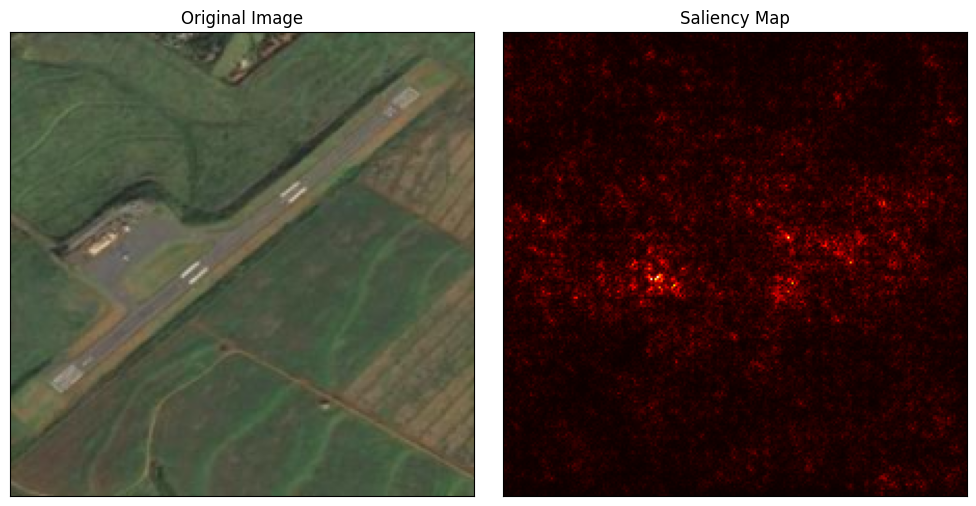

Saliency map generated.


In [5]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Model Definition ---
def load_trained_resnet50(model_path, num_classes=45, device='cpu'):
    """
    Loads a ResNet50 model, modifies its classifier, and loads trained weights.
    """
    # Load a pre-trained ResNet50 model
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2) # Or None if you don't want pretrained imagenet weights before loading yours

    # Freeze all parameters first, then unfreeze layer4 as in the notebook
    # This step is important if you were fine-tuning only specific layers.
    # For saliency, we primarily need the model structure and loaded weights.
    for param in model.parameters():
        param.requires_grad = False

    # Modify the fully connected layer for the new number of classes
    num_ftrs = model.fc.in_features
    # In your notebook, you added a Dropout layer. We'll replicate that.
    dropout_rate = 0.5 # As per your notebook
    model.fc = nn.Sequential(
        nn.Dropout(p=dropout_rate),
        nn.Linear(num_ftrs, num_classes)
    )

    # Load the trained weights
    # **IMPORTANT**: Replace 'path/to/your/trained_resnet50_mc_dropout_model.pth'
    # with the actual path to your .pth file.
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Model weights loaded successfully from {model_path}")
    else:
        print(f"Warning: Model weights file not found at {model_path}. Using a model with initial (or ImageNet) weights.")
        print("Saliency map will not reflect your specific training.")

    model = model.to(device)
    model.eval() # Set the model to evaluation mode
    return model

# --- Image Transformations ---
# These should match the transformations used during training in your notebook
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Inverse normalization for displaying the image
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

# --- Saliency Map Function (as provided by you) ---
def saliency(img_tensor, model):
    """
    Generates and displays a saliency map for a given image tensor and model.
    Note: Modified to take an image tensor as input directly.
    """
    # We don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False # Ensure weights are frozen

    # Set model in eval mode (already done if loaded correctly, but good practice)
    model.eval()

    # We want to calculate gradient of highest score w.r.t. input
    # So set requires_grad to True for input
    img_tensor.requires_grad = True

    # Forward pass to calculate predictions
    preds = model(img_tensor)
    score, indices = torch.max(preds, 1) # Get the score for the predicted class

    # Backward pass to get gradients of score of the predicted class w.r.t. input image
    score.backward()

    # Get max along channel axis from the absolute gradients
    # input.grad[0] because img_tensor is expected to be a batch of 1
    slc, _ = torch.max(torch.abs(img_tensor.grad[0]), dim=0)

    # Normalize to [0..1]
    if slc.max() - slc.min() > 0: # Avoid division by zero if slc is flat
        slc = (slc - slc.min()) / (slc.max() - slc.min())
    else:
        slc = torch.zeros_like(slc) # If flat, make it all zeros

    # Apply inverse transform on image for display
    with torch.no_grad():
        input_img_display = inv_normalize(img_tensor[0].cpu()) # Move to CPU for numpy conversion

    # Plot image and its saliency map
    plt.figure(figsize=(10, 5)) # Adjusted figure size for better layout
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img_display.detach().numpy(), (1, 2, 0)))
    plt.title("Original Image")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 2, 2)
    plt.imshow(slc.cpu().numpy(), cmap=plt.cm.hot) # Move slc to CPU for numpy conversion
    plt.title("Saliency Map")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout() # Adjust layout to prevent overlap
    plt.show()

    return slc # Return the saliency map tensor if needed

# --- Main Execution ---
if __name__ == '__main__':
    # Determine device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # --- IMPORTANT: USER ACTION REQUIRED ---
    # 1. Provide the path to your trained model's .pth file
    MODEL_WEIGHTS_PATH = "trained_resnet50_mc_dropout_model.pth"
    # Example: MODEL_WEIGHTS_PATH = "./output_mc_dropout/trained_resnet50_mc_dropout_model.pth"

    # 2. Provide the path to an image from your test directory
    IMAGE_PATH = "airport_014.jpg"
    # Example: IMAGE_PATH = "D:/Study/resics_applied_ml_project/splitted_data/test/airplane/airplane_001.jpg"
    # For a placeholder if you don't have an image path yet:
    # IMAGE_PATH = None # Or a path to a default image if you include one

    # --- End of USER ACTION REQUIRED ---


    # Load the model
    # Note: num_classes should match the output of your trained model (45 in your notebook)
    try:
        trained_model = load_trained_resnet50(model_path=MODEL_WEIGHTS_PATH, num_classes=45, device=device)
    except Exception as e:
        print(f"Error loading the model: {e}")
        print("Please ensure MODEL_WEIGHTS_PATH is correct and the model structure matches.")
        exit()

    # Load and transform the image
    if IMAGE_PATH and os.path.exists(IMAGE_PATH):
        try:
            img_pil = Image.open(IMAGE_PATH).convert('RGB')
        except FileNotFoundError:
            print(f"Error: Image file not found at {IMAGE_PATH}")
            print("Please provide a valid path to an image from your test directory.")
            exit()
        except Exception as e:
            print(f"Error opening image: {e}")
            exit()

        # Apply transformations and add batch dimension
        img_tensor_transformed = manual_transforms(img_pil).unsqueeze(0).to(device)

        # Generate and display saliency map
        print("Generating saliency map...")
        saliency_map_tensor = saliency(img_tensor_transformed, trained_model)
        print("Saliency map generated.")

    elif MODEL_WEIGHTS_PATH and os.path.exists(MODEL_WEIGHTS_PATH) and (not IMAGE_PATH or not os.path.exists(IMAGE_PATH)):
        print("-" * 50)
        print("Model weights seem to be loaded (or a placeholder path was found).")
        print("However, the IMAGE_PATH is not set or the image file was not found.")
        print(f"Current IMAGE_PATH: {IMAGE_PATH}")
        print("Please update IMAGE_PATH in the script to point to a valid image from your test set to generate a saliency map.")
        print("-" * 50)
    else:
        print("-" * 50)
        print("Neither model weights nor a valid image path were provided or found.")
        print("Please update MODEL_WEIGHTS_PATH and IMAGE_PATH in the script.")
        print("This script will now exit as it cannot proceed without these files.")
        print("-" * 50)

